# Imports

In [1]:
import os
import re
from natsort import natsorted
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Circle

from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.flow_map import Points
from py_wake.flow_map import HorizontalGrid

from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

# Turbines and site

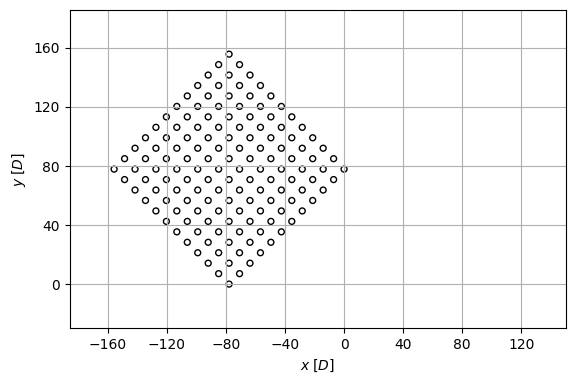

In [2]:
po = [0, 0, 0, 0, 0, 0, 0, 49, 97, 183, 268, 369, 470, 580, 722, 
      900, 1103, 1315, 1526, 1705, 1883, 1940, 1980, 1995, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 
      2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000] # https://www.thewindpower.net/turbine_en_779_vestas_v100-2000.php
ct = 0.8 * np.ones_like(po)
u = np.linspace(0, len(po), len(po))

turbine = WindTurbine(name = 'Turbines',
                      diameter = 100,
                      hub_height = 100,
                      powerCtFunction = PowerCtTabular(u, po, 'kW', ct))

site = UniformSite(shear=PowerShear(h_ref=turbine.hub_height(), alpha=.1))

n_rows = 12
n_cols = 12

D = turbine.diameter()
s = 10 * D

x_grid, y_grid = np.meshgrid(np.arange(n_cols) * s,
                             np.arange(n_rows) * s)

x = x_grid.ravel()
y = y_grid.ravel()

theta_deg = 45
theta_rad = -np.radians(theta_deg)

rotation_matrix = np.array([
    [np.cos(theta_rad), -np.sin(theta_rad)],
    [np.sin(theta_rad),  np.cos(theta_rad)]
])

xy_rotated = rotation_matrix @ np.vstack([x, y])
x, y = xy_rotated[0], xy_rotated[1]

x = x - np.max(x) # Set x=0 at downstream edge
y = y - np.min(y) # Set y=0 at bottommost turbine

padding = 30 # Padding for display [D]

fig, ax = plt.subplots()

# Plot each turbine as a circle with diameter = 1 (in units of D)
for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), 2, color='black', fill=False)
    ax.add_patch(circle)

# Set padded limits
ax.set_xlim(min(x)/D - padding, max(x)/D + 5*padding)
ax.set_ylim(min(y)/D - padding, max(y)/D + padding)

# Now retrieve actual limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

tick_interval = 40  # in units of D

# Generate a wide range of ticks
xticks = np.arange(-1000, 1000, tick_interval)
yticks = np.arange(-1000, 1000, tick_interval)

# Clip to axes limits
xticks = xticks[(xticks >= xlim[0]) & (xticks <= xlim[1])]
yticks = yticks[(yticks >= ylim[0]) & (yticks <= ylim[1])]

# Apply ticks
ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.set_xlabel(r"$x\;[D]$")
ax.set_ylabel(r"$y\;[D]$")
ax.set_aspect('equal')
ax.grid(True)
plt.show()

# Flow map

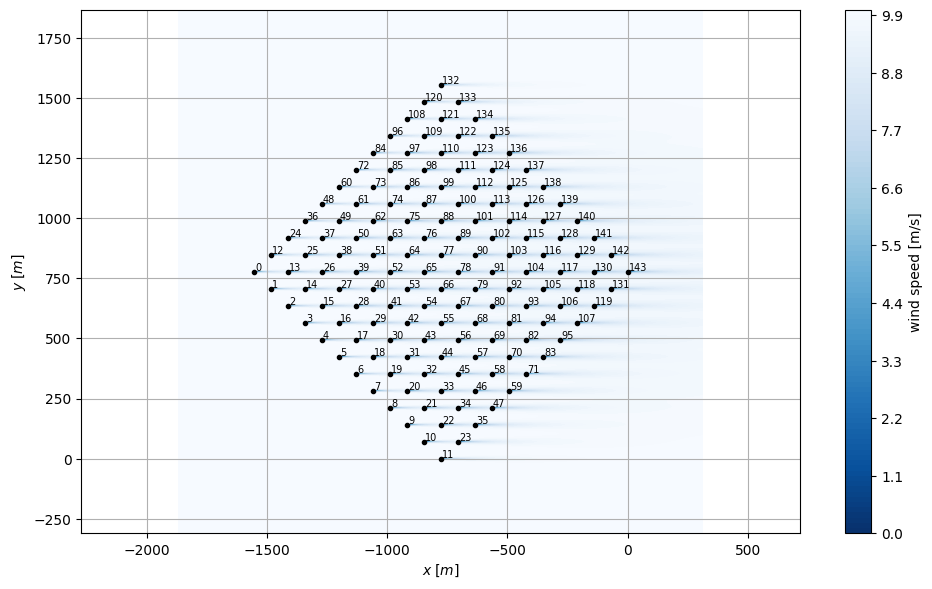

In [3]:
# Run your simulation
wdir = 270  # [deg]
wsp = 10  # [m/s]
ti = 0.1

mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize=(10, 6))

wfm = PropagateDownwind(site, turbine,
                        wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                        superpositionModel=LinearSum())
sim = wfm(x, y, ws=wsp, wd=wdir, TI=ti) # Skal gange størrelsen op med 10, da PyWake internt skalerer...?

sim.flow_map().plot_wake_map(ax=ax, normalize_with=wsp, plot_windturbines=True)

'''
for x_t, y_t in zip(x, y):
    circle = Circle((x_t/D, y_t/D), radius=2, color='black', fill=False)
    ax.add_patch(circle)
'''
    
ax.set_xlabel(r"$x \; [m]$")
ax.set_ylabel(r"$y \; [m]$")
ax.set_aspect('equal')
ax.grid(True)
plt.tight_layout()
plt.show()

# Load validation data from TDM

In [4]:
validation_data_path = "../ArbitraryLayouts/ValidationData"

# List only files, sorted alphabetically (lex order)
validation_files = natsorted(
    [f for f in os.listdir(validation_data_path) if os.path.isfile(os.path.join(validation_data_path, f))]
)

validation_datasets = {}
for file in validation_files:
    if file.endswith('.csv'):
        file_path = os.path.join(validation_data_path, file)
        validation_datasets[file] = pd.read_csv(file_path)

print("Loaded datasets:", list(validation_datasets.keys()))

Loaded datasets: ['mREC100D.csv']


# Wind speed profiles

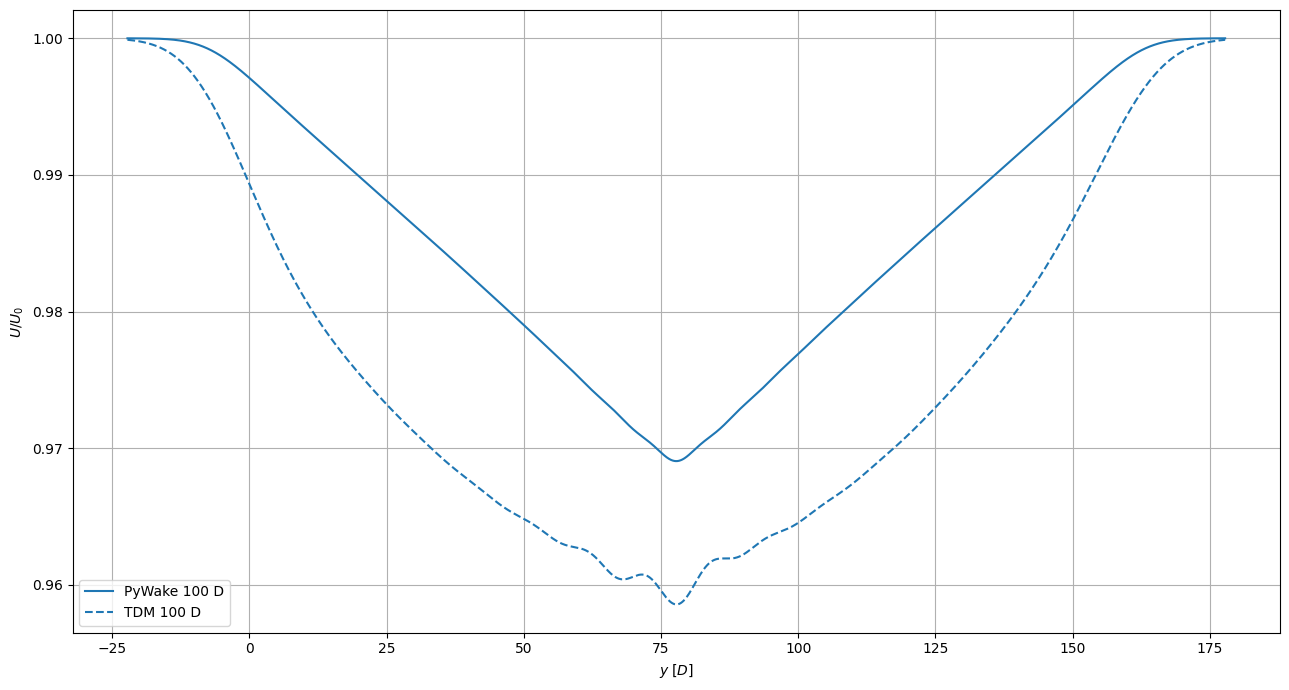

In [ ]:
# --- Your existing setup ---
d_downstream = [100, 500]  # Downstream distances [Park lengths]
m_downstream = [d * D for d in d_downstream]  # [m]

y_agreed = 20000
w_meas = int((y_agreed - max(y)) / 2)  # Half-width of measurement area [m]

y_range = np.linspace(min(y) - w_meas, max(y) + w_meas, y_agreed)
y_meas = np.tile(y_range[:, np.newaxis], (1, len(m_downstream)))  # Shape: (y_agreed, len(m_downstream))

ws_meas = np.zeros_like(y_meas)

# --- Create plot ---
fig, ax = plt.subplots(figsize=(13, 7))
ax.set_xlabel(r'$y \; [D]$')
ax.set_ylabel(r'$ U/U_0 $')
ax.grid(True)

# --- Plot PyWake profiles ---
for i, m in enumerate(m_downstream):
    x_meas = np.full(y_meas.shape[0], max(x) + m)

    ws_meas[:, i] = np.squeeze(
        sim.flow_map(Points(
            x=x_meas,
            y=y_meas[:, i],
            h=turbine.hub_height() * np.ones_like(y_meas[:, i])
        )).WS_eff.values
    )
    
    ax.plot(y_meas[:, i] / D, ws_meas[:, i] / wsp, label=f'PyWake {d_downstream[i]} D')


for i, file in enumerate(validation_files):
    # Extract first number from filename as downstream distance
    match = re.search(r'(\d+)', file)
    if match:
        downstream_distance = int(match.group(1))
    else:
        downstream_distance = None

    tdm_data = validation_datasets[file]

    # Extract second column values (assumed to align with y_range)
    tdm_values = tdm_data.iloc[:, 1].values

    # Find which PyWake profile this corresponds to, fallback to index i if no match
    if downstream_distance in d_downstream:
        idx = d_downstream.index(downstream_distance)
    else:
        idx = i if i < len(d_downstream) else 0  # fallback index

    # Use same color as corresponding PyWake line
    color = ax.get_lines()[idx].get_color()
    
    ax.plot(y_range / D, tdm_values, linestyle='--', color=color, label=f'TDM {downstream_distance} D')

    
ax.legend()
plt.tight_layout()
plt.show()


# Total wsp deficit integration

In [6]:
# Integrate from 0 to wsp over y_range and subtract the integral of ws_meas over y_range
integrated_ws = {}
for i, d in enumerate(d_downstream):
    wsp_integral = np.trapezoid(np.full_like(y_range, wsp), y_range)
    ws_meas_integral = np.trapezoid(ws_meas[:, i], y_range)
    integrated_ws[d] = wsp_integral - ws_meas_integral
    print(f"Integrated wind speed at {d} D: {integrated_ws[d]:.2f}")

Integrated wind speed at 100 D: 2678.80


# Measurement lines

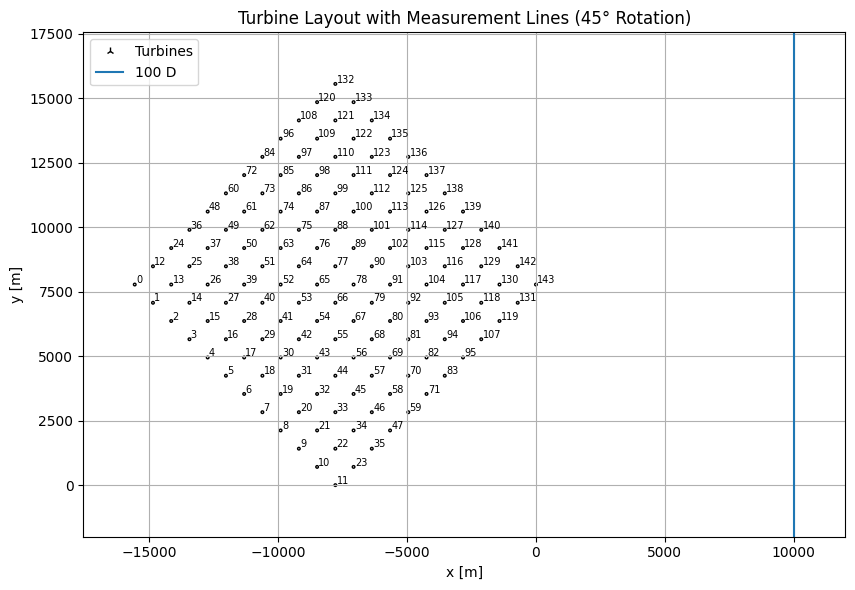

In [7]:
padding = 2000  # Padding for display

fig, ax = plt.subplots(figsize=(10, 6))
turbine.plot(x, y, ax=ax)

# Set plot limits with padding
ax.set_xlim(min(x) - padding, max(x) + max(m_downstream) + padding)
ax.set_ylim(min(y) - padding, max(y) + padding)

# Draw vertical lines at each x_meas (same for all points in a column)
color_map = plt.get_cmap('tab10')
for i, m in enumerate(m_downstream):
    x_line = max(x) + m
    color = color_map(i % 10)
    ax.axvline(x=x_line, color=color, label=f'{d_downstream[i]} D')  # Add label for legend

# Beautify
ax.set_title(f"Turbine Layout with Measurement Lines ({theta_deg}° Rotation)")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect('equal')
ax.grid(True)

# Only show one legend entry per PL
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))  # Remove duplicate labels
ax.legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()

# Wake min y-coord.

In [8]:
# Define a threshold for wake calculation (e.g., 95% of free-stream wind speed)
threshold = 0.99999 * wsp

# Calculate and print the lowest y-value of the wake for each downstream distance
for i, d in enumerate(d_downstream):
    wake_indices = np.where(ws_meas[:, i] < threshold)[0]
    if len(wake_indices) > 0:
        lowest_y = y_range[wake_indices[0]]
        print(f"Lowest y-value of the wake at {d} D: {lowest_y:.2f} m")
    else:
        print(f"No wake detected at {d} D")

Lowest y-value of the wake at 100 D: -1893.01 m
